### TP 2 Vision Computer 

- Objetivo:
Implementar un detector de máximo enfoque sobre un video aplicando técnicas de análisis espectral similar al que utilizan las
cámaras digitales modernas. El video a procesar será: “focus_video.mov”.
1. Se debe implementar un algoritmo que dada una imagen, o región, calcule la métrica propuesta en el paper "Image
Sharpness Measure for Blurred Images in Frequency Domain“ y realizar tres experimentos:
1. Medición sobre todo el frame.
2. Medición sobre una ROI ubicada en el centro del frame. Area de la ROI = 5 o 10% del area total del frame.
Opcional:
1. Medición sobre una matriz de enfoque compuesta por un arreglo de NxM elementos rectangulares equiespaciados. N y M son valores
arbitrarios, probar con varios valores 3x3, 7x5, etc … (al menos 3)
Para cada experimento se debe presentar :
- Una curva o varias curvas que muestren la evolución de la métrica frame a frame donde se vea claramente cuando el algoritmo detecto el punto
de máximo enfoque.
2. Cambiar la métrica de enfoque eligiendo uno de los algoritmos explicados en el apéndice de: Analysis of focus measure
operators in shapefrom focus.
1. Medicion de foco en toda la imagen
El algoritmo de detección a implementar debe detectar y devolver los puntos de máximo enfoque de manera
automática.


In [65]:
def mostrar_imagen(imagen, titulo=''):
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB))
    plt.title(titulo)
    plt.axis('off')
    plt.show()

In [66]:
import cv2
import numpy as np

def sharpness_FM_paper(img_bgr):

    if img_bgr.ndim == 3:
        gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY).astype(np.float32)
    else:
        gray = img_bgr.astype(np.float32)

    F  = np.fft.fft2(gray)
    Fc = np.fft.fftshift(F)
    AF = np.abs(Fc)

    M = AF.max()
    thres = M / 1000.0  # umbral aclarado en el paper
    TH = np.sum(AF > thres)

    H, W = AF.shape
    FM = TH / (H * W)   # normalizacion
    return float(FM)

In [67]:
def get_central_roi(img_bgr, roi_percent=0.10):
    h, w = img_bgr.shape[:2]
    rh, rw = int(h*roi_percent), int(w*roi_percent)
    y0 = (h - rh) // 2
    x0 = (w - rw) // 2
    return img_bgr[y0:y0+rh, x0:x0+rw]

In [68]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

video_path = 'data/focus_video.mov'
cap = cv2.VideoCapture(video_path)

sharp_full, sharp_roi, frames = [], [], []
if not cap.isOpened():
    raise RuntimeError("No se pudo abrir el video")

idx = 0
stride = 1       
while True:
    ret, frame = cap.read()
    if not ret: break
    if idx % stride == 0:
        FM_full = sharpness_FM_paper(frame)
        roi = get_central_roi(frame, roi_percent=0.10)
        FM_roi  = sharpness_FM_paper(roi)
        sharp_full.append(FM_full)
        sharp_roi.append(FM_roi)
        frames.append(idx)
    idx += 1

cap.release()
cv2.destroyAllWindows()


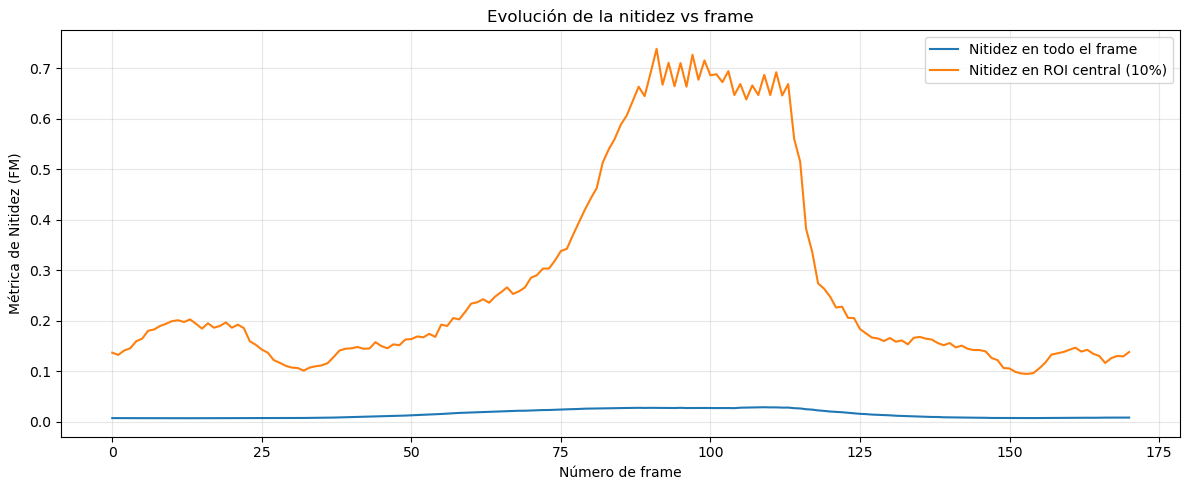

In [69]:
# Graficar 
plt.figure(figsize=(12,5))
plt.plot(frames, sharp_full, label='Nitidez en todo el frame')
plt.plot(frames, sharp_roi, label='Nitidez en ROI central (10%)')
plt.title('Evolución de la nitidez vs frame')
plt.xlabel('Número de frame'); plt.ylabel('Métrica de Nitidez (FM)')
plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()


Frames leídos: 171


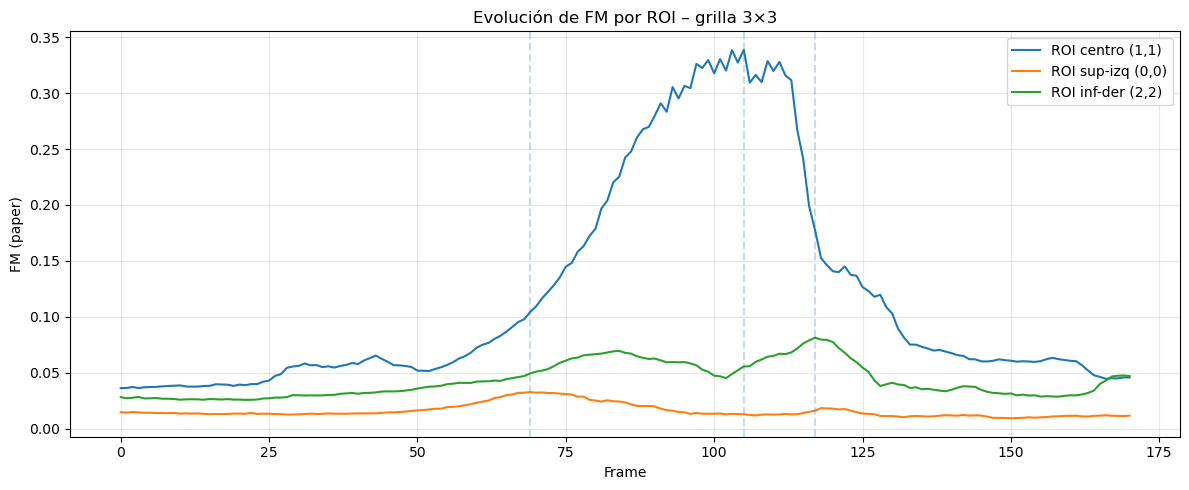

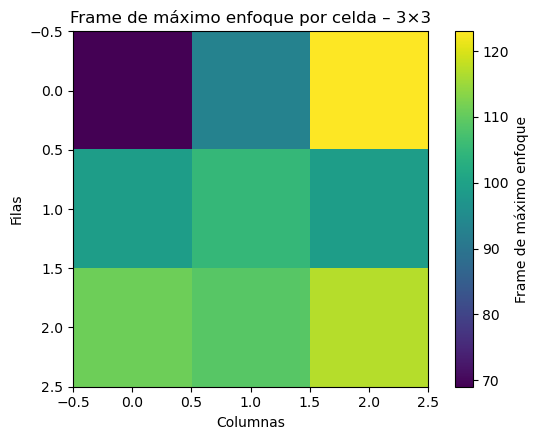

[3x3] frame medio del máximo: 102.8 | FM_max medio: 0.1423


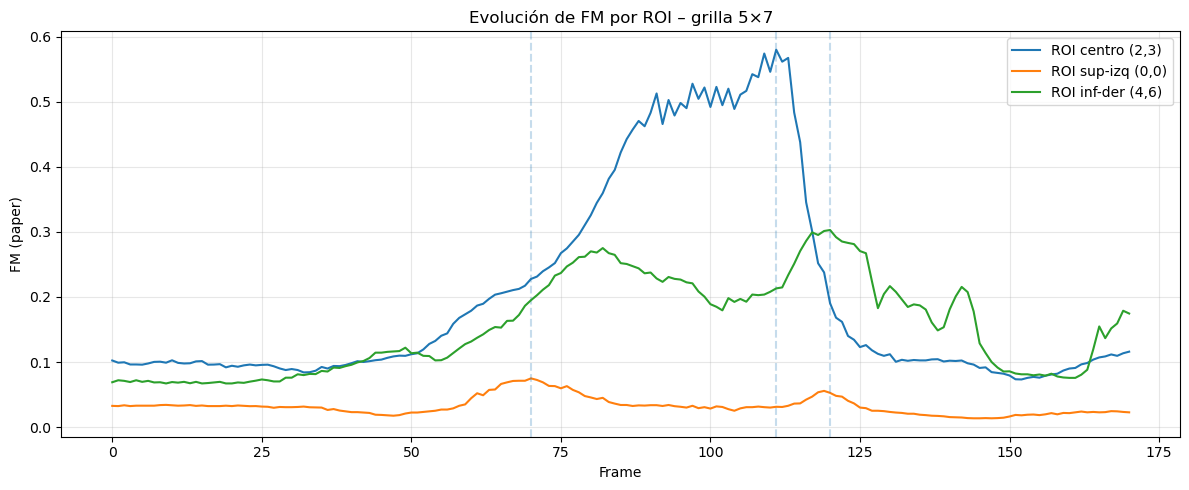

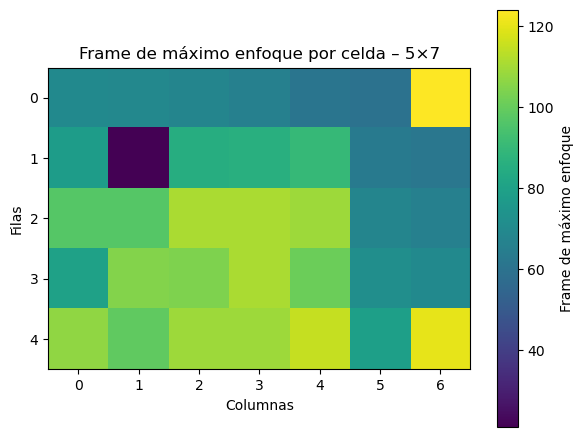

[5x7] frame medio del máximo: 86.9 | FM_max medio: 0.2438


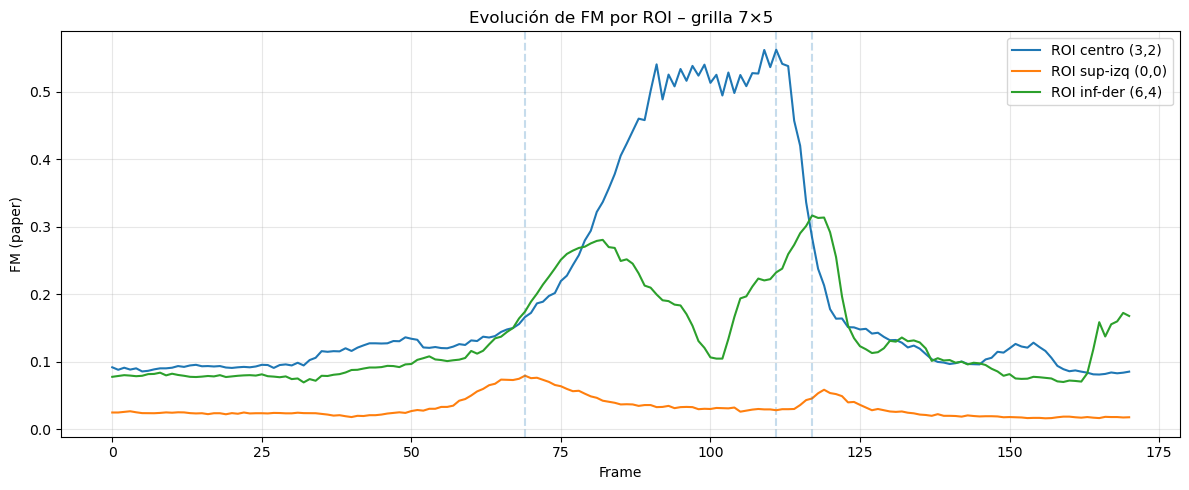

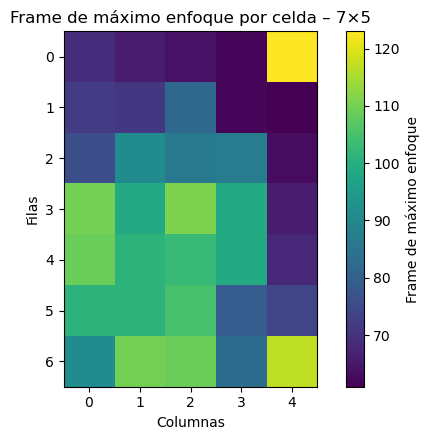

[7x5] frame medio del máximo: 87.7 | FM_max medio: 0.2493


In [70]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def split_grid(img, N=3, M=3):
    H, W = img.shape[:2]
    h = H // N
    w = W // M
    rois = []
    for i in range(N):
        for j in range(M):
            y0, x0 = i*h, j*w
            roi = img[y0:y0+h, x0:x0+w]
            rois.append(((i, j), roi))
    return rois  

video_path = 'data/focus_video.mov'  
grids = [(3,3), (5,7), (7,5)]        
stride = 1                         

cap0 = cv2.VideoCapture(video_path)
if not cap0.isOpened():
    raise RuntimeError("No se pudo abrir el video")

frames_bgr = []
while True:
    ret, f = cap0.read()
    if not ret: break
    frames_bgr.append(f)
cap0.release()
num_frames = len(frames_bgr)
print(f"Frames leídos: {num_frames}")

for (N, M) in grids:
    # Matrix FM: shape (num_frames, N*M)
    fm_mat = np.zeros((num_frames, N*M), dtype=np.float32)

    for t in range(0, num_frames, stride):
        frame = frames_bgr[t]
        rois = split_grid(frame, N=N, M=M)
        for k, ((ri, rj), roi) in enumerate(rois):
            fm_mat[t, k] = sharpness_FM_paper(roi)

    
    idx_center = (N//2)*M + (M//2)
    idx_tl = 0
    idx_br = N*M - 1

    series = {
        f"ROI centro ({N//2},{M//2})": fm_mat[:, idx_center],
        "ROI sup-izq (0,0)": fm_mat[:, idx_tl],
        f"ROI inf-der ({N-1},{M-1})": fm_mat[:, idx_br]
    }

    plt.figure(figsize=(12,5))
    for name, y in series.items():
        plt.plot(y, label=name)
        t_max = int(np.argmax(y))
        plt.axvline(t_max, linestyle='--', alpha=0.25)

    plt.title(f"Evolución de FM por ROI – grilla {N}×{M}")
    plt.xlabel("Frame"); plt.ylabel("FM (paper)")
    plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout()
    plt.show()

    t_max_per_cell = np.argmax(fm_mat, axis=0)  # argmax por columna (celda)
    heat = t_max_per_cell.reshape(N, M)

    plt.figure(figsize=(6,4.5))
    im = plt.imshow(heat, cmap='viridis')
    plt.title(f"Frame de máximo enfoque por celda – {N}×{M}")
    plt.xlabel("Columnas"); plt.ylabel("Filas")
    plt.colorbar(im, label="Frame de máximo enfoque")
    plt.tight_layout(); plt.show()

    fm_max = fm_mat.max(axis=0).reshape(N, M)
    print(f"[{N}x{M}] frame medio del máximo: {heat.mean():.1f} | FM_max medio: {fm_max.mean():.4f}")
